In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/COVID-19_Radiography_Dataset"
!pip install pip install tensorflow-addons

Mounted at /content/gdrive
 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia'
 Normal			     'Viral Pneumonia.metadata.xlsx'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.3 MB/s eta 0:00:00


In [2]:
import keras 
import pandas as pd
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from IPython import display
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import img_to_array
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from glob import glob
from functools import partial

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow_addons.layers import InstanceNormalization
from PIL import Image


import gdown
from zipfile import ZipFile
# for reproducibility - ref https://machinelearningmastery.com/reproducible-results-neural-networks-keras/ and https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
np.random.seed(9)
tf.keras.utils.set_random_seed(10)

# loading data from gdrive
chest_xray_dataset = os.path.abspath("/content/gdrive/My Drive/COVID 19 CHEST XRAY/images")
chest_xray_dataset_annotations = os.path.abspath("/content/gdrive/My Drive/COVID 19 CHEST XRAY/metadata.csv")
radiography_dataset = os.path.abspath("/content/gdrive/My Drive/COVID-19_Radiography_Dataset/")
xray_covid19_dataset = os.path.abspath("/content/gdrive/My Drive/xray_dataset_covid19/")



In [3]:
#@markdown #**Anti-Disconnect for Google Colab**
#@markdown ## Run this to stop it from disconnecting automatically 
#@markdown  **(It will anyhow disconnect after 6 - 12 hrs for using the free version of Colab.)**
#@markdown  *(Colab Pro users will get about 24 hrs usage time)*
#@markdown ---
# taken from https://colab.research.google.com/github/justinjohn0306/VQGAN-CLIP/blob/main/VQGAN%2BCLIP_%28z%2Bquantize_method_with_augmentations%2C_user_friendly_interface%29.ipynb#scrollTo=XHyPd4oxVp_l stops colab disconnecting
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
IPython.display.Javascript(js_code)

<IPython.core.display.Javascript object>

Found 3616 files belonging to 1 classes.


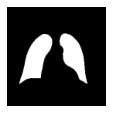

In [ ]:
# load images
image_size = (128, 128)
train_datagen = ImageDataGenerator(rescale=1./255)
dataset = keras.utils.image_dataset_from_directory(
    radiography_dataset + '/COVID/masks', label_mode=None, image_size=image_size, batch_size=128
)
for images in dataset.take(4):
  for i in range(1):
      ax = plt.subplot(2, 2, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.axis("off")


# Code taken from ref https://keras.io/examples/generative/vae/ and refactored

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)

x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_64 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_107 (Conv2D)            (None, 64, 64, 32)   896         ['input_64[0][0]']               
                                                                                                  
 conv2d_108 (Conv2D)            (None, 32, 32, 64)   18496       ['conv2d_107[0][0]']             
                                                                                                  
 conv2d_109 (Conv2D)            (None, 16, 16, 128)  73856       ['conv2d_108[0][0]']       

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_66 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_65 (Dense)            (None, 4096)              12288     
                                                                 
 reshape_39 (Reshape)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_177 (Conv2  (None, 16, 16, 128)      73856     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_178 (Conv2  (None, 32, 32, 64)       73792     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_179 (Conv2  (None, 64, 64, 32)       1846

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mae(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def get_vae():
      return VAE(name='VAERadiographyCOVID')

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(dataset, epochs=30)
encoder.save('/content/gdrive/My Drive/VAEModelsFinalMasters/Radiography/COVID/COVIDVAEMaskEncoder.tf')
decoder.save('/content/gdrive/My Drive/VAEModelsFinalMasters/Radiography/COVID/COVIDVAEEMaskDecorder.tf')

Epoch 1/30
29/29 [==============================] - 6s 44ms/step - loss: 1026743.2063 - reconstruction_loss: 1024384.0625 - kl_loss: 22.0228
Epoch 2/30
29/29 [==============================] - 2s 46ms/step - loss: 1018311.6292 - reconstruction_loss: 1021443.8125 - kl_loss: 2.8280e-04
Epoch 3/30
29/29 [==============================] - 2s 46ms/step - loss: 1023210.9208 - reconstruction_loss: 1023090.3750 - kl_loss: 3.5189e-04
Epoch 4/30
29/29 [==============================] - 2s 46ms/step - loss: 1019242.0250 - reconstruction_loss: 1024427.7500 - kl_loss: 3.5806e-04
Epoch 5/30
29/29 [==============================] - 2s 45ms/step - loss: 1020228.7229 - reconstruction_loss: 1022647.0625 - kl_loss: 3.6091e-04
Epoch 6/30
29/29 [==============================] - 2s 45ms/step - loss: 1017621.8083 - reconstruction_loss: 1023617.8125 - kl_loss: 3.7312e-04
Epoch 7/30
29/29 [==============================] - 2s 44ms/step - loss: 1024090.5208 - reconstruction_loss: 1021796.5000 - kl_loss: 3.7729

1/1 [==============================] - 0s 19ms/step


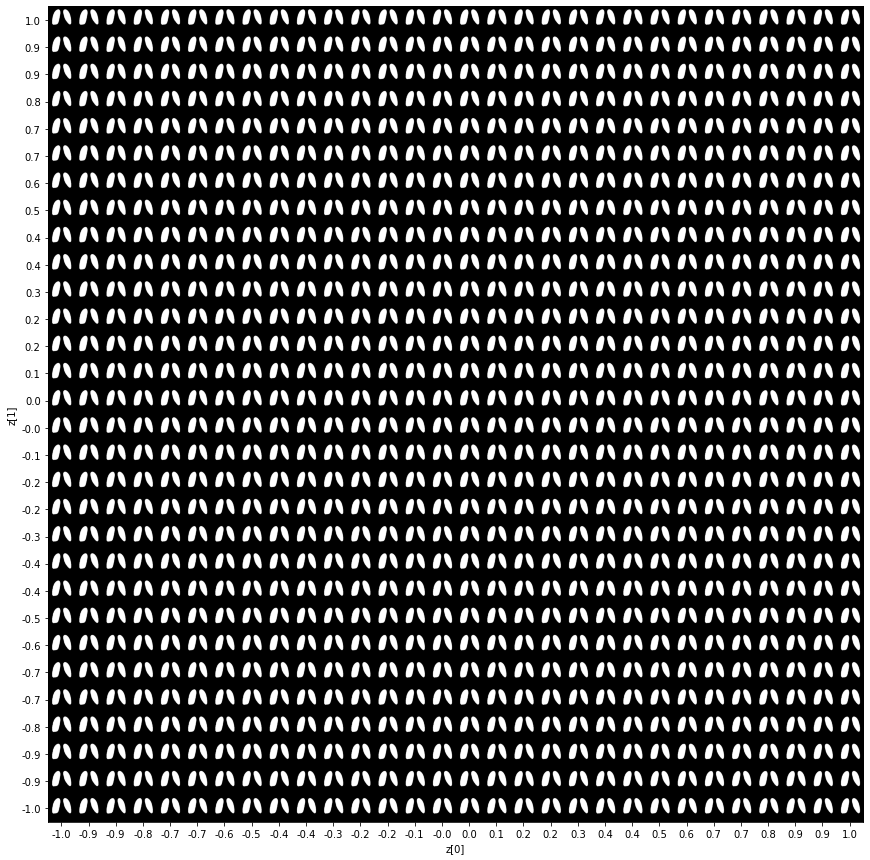

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 128
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure,cmap='Greys_r')
    plt.show()


plot_latent_space(vae)

Found 3616 files belonging to 1 classes.


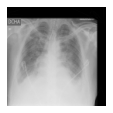

In [31]:
# load images
image_size = (128, 128)
train_datagen = ImageDataGenerator(rescale=1./255)
dataset = keras.utils.image_dataset_from_directory(
    radiography_dataset + '/COVID/images', label_mode=None, image_size=image_size, batch_size=8
)
for images in dataset.take(4):
  for i in range(1):
      ax = plt.subplot(2, 2, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.axis("off")


In [32]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [44]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 64, 64, 32)   896         ['input_14[0][0]']               
                                                                                                  
 conv2d_13 (Conv2D)             (None, 32, 32, 64)   18496       ['conv2d_12[0][0]']              
                                                                                                  
 conv2d_14 (Conv2D)             (None, 16, 16, 128)  73856       ['conv2d_13[0][0]']        

In [45]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_14 (Dense)            (None, 4096)              12288     
                                                                 
 reshape_9 (Reshape)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_55 (Conv2D  (None, 16, 16, 128)      73856     
 Transpose)                                                      
                                                                 
 conv2d_transpose_56 (Conv2D  (None, 32, 32, 64)       73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_57 (Conv2D  (None, 64, 64, 32)       1846

In [46]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mae(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def get_vae():
      return VAE(name='VAERadiographyCOVID')

In [47]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(dataset, epochs=30)
encoder.save('/content/gdrive/My Drive/VAEModelsFinalMasters/Radiography/COVID/COVIDVAEXrayEncoder.tf')
decoder.save('/content/gdrive/My Drive/VAEModelsFinalMasters/Radiography/COVID/COVIDVAEEXrayDecorder.tf')

Epoch 1/30
452/452 [==============================] - 10s 11ms/step - loss: 114797116990.5982 - reconstruction_loss: 2270601.2500 - kl_loss: 20204535808.0000
Epoch 2/30
452/452 [==============================] - 5s 11ms/step - loss: 2263346.0613 - reconstruction_loss: 2270427.7500 - kl_loss: 6.3575e-04
Epoch 3/30
452/452 [==============================] - 5s 11ms/step - loss: 2261964.0132 - reconstruction_loss: 2270427.2500 - kl_loss: 6.1183e-04
Epoch 4/30
452/452 [==============================] - 5s 10ms/step - loss: 2261738.1222 - reconstruction_loss: 2270427.5000 - kl_loss: 5.5906e-04
Epoch 5/30
452/452 [==============================] - 5s 10ms/step - loss: 2264035.8013 - reconstruction_loss: 2270428.0000 - kl_loss: 4.8834e-04
Epoch 6/30
452/452 [==============================] - 5s 10ms/step - loss: 2261715.0475 - reconstruction_loss: 2270428.0000 - kl_loss: 4.0649e-04
Epoch 7/30
452/452 [==============================] - 5s 10ms/step - loss: 2264249.1479 - reconstruction_loss: 2

1/1 [==============================] - 0s 20ms/step


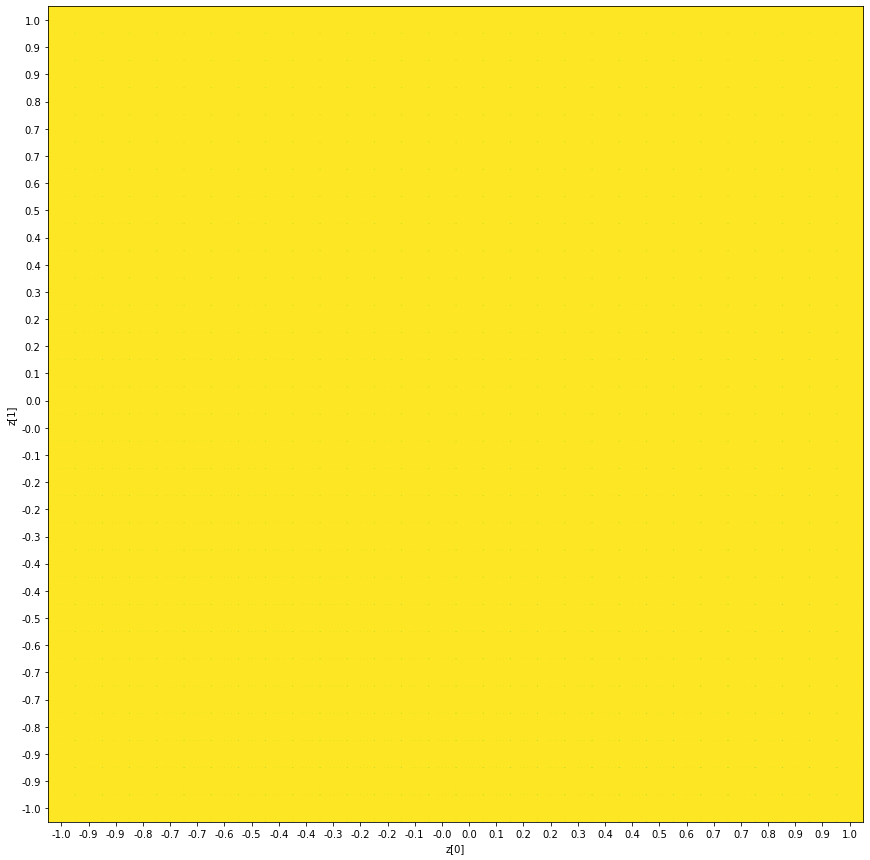

In [52]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 128
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()


plot_latent_space(vae)

In [ ]:
# load images
image_size = (128, 128)
img_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    radiography_dataset + '/Viral Pneumonia/masks', label_mode=None, image_size=image_size, batch_size=8,crop_to_aspect_ratio=True
)

dataset = img_dataset.map(lambda x: x / 255.0)

In [18]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [19]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 64, 64, 32)   896         ['input_5[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 16, 16, 128)  73856       ['conv2d_4[0][0]']         

In [20]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 4096)              12288     
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 16, 16, 128)      73856     
 Transpose)                                                      
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 32, 32, 64)       73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_19 (Conv2D  (None, 64, 64, 32)       1846

In [21]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mae(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def get_vae():
      return VAE(name='VAERadiographyCOVID')

In [22]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(dataset, epochs=30)
encoder.save('/content/gdrive/My Drive/VAEModelsFinalMasters/Radiography/Pneumonia/PNEUMONIAVAEMaskEncoder.tf')
decoder.save('/content/gdrive/My Drive/VAEModelsFinalMasters/Radiography/Pneumonia/PNEUMONIAVAEEMaskDecorder.tf')

Epoch 1/30
169/169 [==============================] - 5s 8ms/step - loss: 5365.7683 - reconstruction_loss: 3903.0173 - kl_loss: 22.2091
Epoch 2/30
169/169 [==============================] - 2s 8ms/step - loss: 2173.2754 - reconstruction_loss: 2003.8478 - kl_loss: 2.0974e-04
Epoch 3/30
169/169 [==============================] - 2s 9ms/step - loss: 1919.9738 - reconstruction_loss: 1868.4684 - kl_loss: 4.6107e-04
Epoch 4/30
169/169 [==============================] - 2s 9ms/step - loss: 1902.1496 - reconstruction_loss: 1860.5653 - kl_loss: 9.2309e-04
Epoch 5/30
169/169 [==============================] - 2s 9ms/step - loss: 1891.6632 - reconstruction_loss: 1858.1879 - kl_loss: 0.0012
Epoch 6/30
169/169 [==============================] - 2s 9ms/step - loss: 1893.2077 - reconstruction_loss: 1855.8304 - kl_loss: 0.0018
Epoch 7/30
169/169 [==============================] - 2s 9ms/step - loss: 1880.5226 - reconstruction_loss: 1854.9624 - kl_loss: 0.0025
Epoch 8/30
169/169 [======================

1/1 [==============================] - 0s 20ms/step


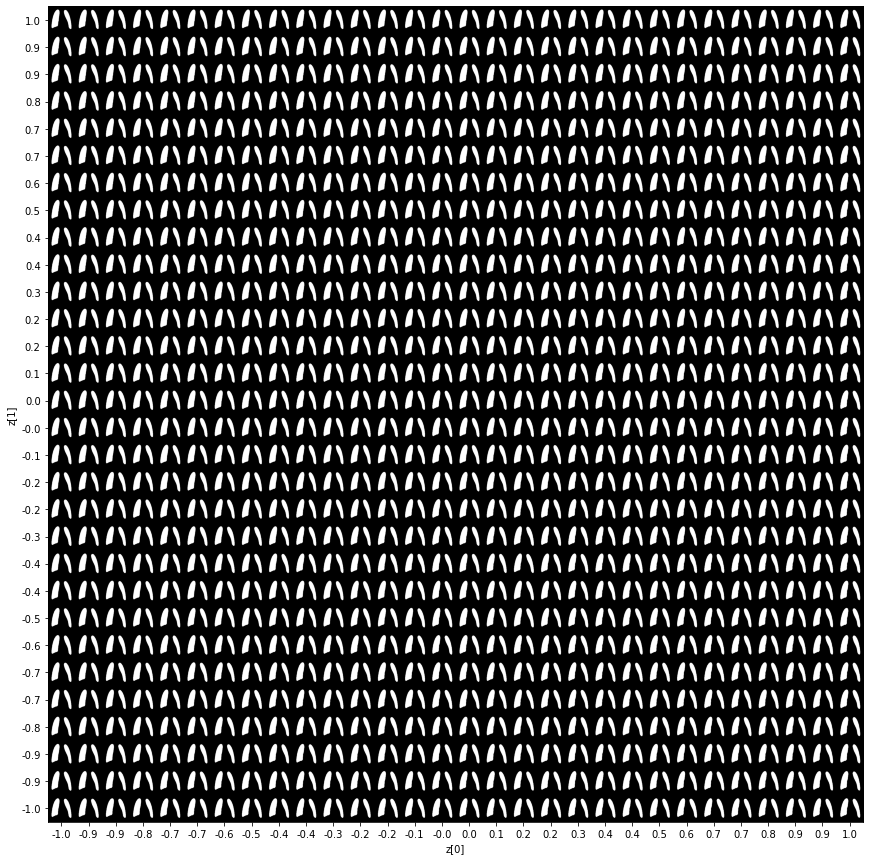

In [23]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 128
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure,cmap='Greys_r')
    plt.show()


plot_latent_space(vae)

# Code taken from https://keras.io/examples/generative/dcgan_overriding_train_step/ and refactored  Radiography DCGANs



In [ ]:
# load images
image_size = (128, 128)
img_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    radiography_dataset + '/COVID/', label_mode=None, image_size=image_size, batch_size=8,crop_to_aspect_ratio=True
)

dataset = img_dataset.map(lambda x: x / 255.0)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Found 7232 files belonging to 1 classes.


In [ ]:
num_channels = 3
num_classes = 1
latent_dim = 256

In [ ]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

257 4


In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

# Create the generator.
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(2048, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=4, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 32768)           

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    def get_gan():
      return GAN(name='DC_GAN_Radiography_COVID')


In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        imageFolder = 0
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save('/content/gdrive/My Drive/Data_Augmented_Radiography_COVID' + '/' + "generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
epochs = 100  # In practice, use ~100 epochs 452


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0.001),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


model = gan.get_gan
# Save the model
generator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_COVIDModel/Generator',save_format='tf')
discriminator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_COVIDModel/Discriminator',save_format='tf')


Epoch 1/100
904/904 [==============================] - 159s 167ms/step - d_loss: 0.6064 - g_loss: 0.9463
Epoch 2/100
904/904 [==============================] - 151s 167ms/step - d_loss: 0.5557 - g_loss: 1.2204
Epoch 3/100
904/904 [==============================] - 151s 167ms/step - d_loss: 0.6494 - g_loss: 1.0036
Epoch 4/100
904/904 [==============================] - 151s 167ms/step - d_loss: 0.6594 - g_loss: 0.9330
Epoch 5/100
904/904 [==============================] - 151s 167ms/step - d_loss: 0.6456 - g_loss: 0.9435
Epoch 6/100
904/904 [==============================] - 151s 167ms/step - d_loss: 0.5360 - g_loss: 1.2437
Epoch 7/100
904/904 [==============================] - 151s 167ms/step - d_loss: 0.5665 - g_loss: 1.1024
Epoch 8/100
904/904 [==============================] - 151s 167ms/step - d_loss: 0.6155 - g_loss: 1.0067
Epoch 9/100
904/904 [==============================] - 151s 167ms/step - d_loss: 0.6102 - g_loss: 1.0518
Epoch 10/100
904/904 [==============================] -

# Creating DCGAN to only generate masks

In [ ]:
# load images
image_size = (128, 128)
img_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    radiography_dataset + '/COVID/masks', label_mode=None, image_size=image_size, batch_size=8,crop_to_aspect_ratio=True
)

dataset = img_dataset.map(lambda x: x / 255.0)

Found 3616 files belonging to 1 classes.


In [ ]:
num_channels = 3
num_classes = 1
latent_dim = 100

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

# Create the generator.
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(16 * 16 * 128),
        layers.Reshape((16, 16, 128)),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=4, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 32768)           

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        imageFolder = 0
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save('/content/gdrive/My Drive/Data_Augmented_Radiography_COVIDMasks' + '/' + "generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
epochs = 100  # In practice, use ~100  


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.00001,momentum=0),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.00001,momentum=0),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


model = gan.get_gan
# Save the model
generator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_COVIDModel/MaskGenerator',save_format='tf')
discriminator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_COVIDModel/MaskDiscriminator',save_format='tf')

Epoch 1/100
452/452 [==============================] - 65s 133ms/step - d_loss: 0.3989 - g_loss: 0.7806
Epoch 2/100
452/452 [==============================] - 31s 69ms/step - d_loss: 0.0890 - g_loss: 2.9036
Epoch 3/100
452/452 [==============================] - 31s 69ms/step - d_loss: 0.0452 - g_loss: 4.8231
Epoch 4/100
452/452 [==============================] - 31s 69ms/step - d_loss: 0.4764 - g_loss: 1.9447
Epoch 5/100
452/452 [==============================] - 31s 69ms/step - d_loss: 0.4935 - g_loss: 1.6120
Epoch 6/100
452/452 [==============================] - 31s 68ms/step - d_loss: 0.6130 - g_loss: 1.0814
Epoch 7/100
452/452 [==============================] - 31s 69ms/step - d_loss: 0.6443 - g_loss: 0.9328
Epoch 8/100
452/452 [==============================] - 31s 69ms/step - d_loss: 0.6287 - g_loss: 0.9099
Epoch 9/100
452/452 [==============================] - 31s 69ms/step - d_loss: 0.6179 - g_loss: 0.9132
Epoch 10/100
452/452 [==============================] - 31s 69ms/step - 

# COVID XRAY

In [ ]:
# load images
image_size = (128, 128)
img_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    radiography_dataset + '/COVID/images', label_mode=None, image_size=image_size, batch_size=8,crop_to_aspect_ratio=True
)

dataset = img_dataset.map(lambda x: x / 255.0)

Found 3616 files belonging to 1 classes.


In [ ]:
num_channels = 3
num_classes = 1
latent_dim = 256

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        imageFolder = 0
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save('/content/gdrive/My Drive/Data_Augmented_Radiography_COVIDXRay' + '/' + "generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
epochs = 100  # In practice, use ~100  


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.00001,momentum=0),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.00001,momentum=0),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


model = gan.get_gan
# Save the model
generator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_COVIDModel/XRayGenerator',save_format='tf')
discriminator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_COVIDModel/XRayDiscriminator',save_format='tf')


Epoch 1/100
452/452 [==============================] - 62s 66ms/step - d_loss: 0.4058 - g_loss: 7.6112
Epoch 2/100
452/452 [==============================] - 30s 66ms/step - d_loss: 0.5833 - g_loss: 6.1387
Epoch 3/100
452/452 [==============================] - 30s 66ms/step - d_loss: 1.3678 - g_loss: 2.9397
Epoch 4/100
452/452 [==============================] - 30s 66ms/step - d_loss: 1.2901 - g_loss: 2.4062
Epoch 5/100
452/452 [==============================] - 30s 66ms/step - d_loss: 1.4481 - g_loss: 0.9817
Epoch 6/100
452/452 [==============================] - 30s 66ms/step - d_loss: 1.5865 - g_loss: 1.1771
Epoch 7/100
452/452 [==============================] - 30s 66ms/step - d_loss: 1.3404 - g_loss: 0.9325
Epoch 8/100
452/452 [==============================] - 30s 66ms/step - d_loss: 1.3514 - g_loss: 1.0558
Epoch 9/100
452/452 [==============================] - 30s 66ms/step - d_loss: 1.2901 - g_loss: 0.8535
Epoch 10/100
452/452 [==============================] - 30s 66ms/step - d

# Pneumonia Masks DCGAN


In [ ]:
# load images
image_size = (128, 128)
img_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    radiography_dataset + '/Viral Pneumonia/masks', label_mode=None, image_size=image_size, batch_size=8,crop_to_aspect_ratio=True
)

dataset = img_dataset.map(lambda x: x / 255.0)

Found 1345 files belonging to 1 classes.


In [ ]:
num_channels = 3
num_classes = 1
latent_dim = 256

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        imageFolder = 0
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save('/content/gdrive/My Drive/Data_Augmented_Radiography_PneumoniaMask' + '/' + "generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
epochs = 100  # In practice, use ~100  


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.00001,momentum=0),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.00001,momentum=0),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


model = gan.get_gan
# Save the model
generator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_PneumoniaModel/MaskGenerator',save_format='tf')
discriminator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_PneumoniaModel/MaskDiscriminator',save_format='tf')


Epoch 1/100
169/169 [==============================] - 36s 110ms/step - d_loss: 0.4507 - g_loss: 0.7043
Epoch 2/100
169/169 [==============================] - 11s 65ms/step - d_loss: 0.3796 - g_loss: 0.7542
Epoch 3/100
169/169 [==============================] - 11s 66ms/step - d_loss: 0.2380 - g_loss: 1.2562
Epoch 4/100
169/169 [==============================] - 11s 66ms/step - d_loss: 0.0663 - g_loss: 2.9898
Epoch 5/100
169/169 [==============================] - 11s 65ms/step - d_loss: 0.0235 - g_loss: 4.8121
Epoch 6/100
169/169 [==============================] - 11s 65ms/step - d_loss: 0.0064 - g_loss: 6.3581
Epoch 7/100
169/169 [==============================] - 11s 65ms/step - d_loss: 4.9314e-04 - g_loss: 7.1903
Epoch 8/100
169/169 [==============================] - 11s 65ms/step - d_loss: 0.0524 - g_loss: 5.7055
Epoch 9/100
169/169 [==============================] - 11s 66ms/step - d_loss: 0.2352 - g_loss: 3.4842
Epoch 10/100
169/169 [==============================] - 11s 66ms/ste

# Pneumonia Xray DCGAN

In [ ]:
# load images
image_size = (128, 128)
img_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    radiography_dataset + '/Viral Pneumonia/images', label_mode=None, image_size=image_size, batch_size=8,crop_to_aspect_ratio=True
)

dataset = img_dataset.map(lambda x: x / 255.0)

Found 1345 files belonging to 1 classes.


In [ ]:
num_channels = 3
num_classes = 1
latent_dim = 256

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        imageFolder = 0
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save('/content/gdrive/My Drive/Data_Augmented_Radiography_PneumoniaXray' + '/' + "generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
epochs = 100  # In practice, use ~100  


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.00001,momentum=0),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.00001,momentum=0),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


model = gan.get_gan
# Save the model
generator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_PneumoniaModel/XRayGenerator',save_format='tf')
discriminator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_PneumoniaModel/XRayDiscriminator',save_format='tf')


Epoch 1/100
169/169 [==============================] - 22s 65ms/step - d_loss: 0.5418 - g_loss: 0.9267
Epoch 2/100
169/169 [==============================] - 11s 65ms/step - d_loss: 0.5987 - g_loss: 0.9223
Epoch 3/100
169/169 [==============================] - 11s 65ms/step - d_loss: 0.6816 - g_loss: 0.8505
Epoch 4/100
169/169 [==============================] - 11s 65ms/step - d_loss: 0.6908 - g_loss: 0.8370
Epoch 5/100
169/169 [==============================] - 11s 65ms/step - d_loss: 0.6945 - g_loss: 0.7632
Epoch 6/100
169/169 [==============================] - 11s 65ms/step - d_loss: 0.6771 - g_loss: 0.7861
Epoch 7/100
169/169 [==============================] - 11s 64ms/step - d_loss: 0.6854 - g_loss: 0.7740
Epoch 8/100
169/169 [==============================] - 11s 65ms/step - d_loss: 0.6839 - g_loss: 0.7728
Epoch 9/100
169/169 [==============================] - 11s 65ms/step - d_loss: 0.6880 - g_loss: 0.7610
Epoch 10/100
169/169 [==============================] - 11s 65ms/step - d

# Pneumonia DCGAN


In [ ]:
# load images
image_size = (128, 128)
img_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    radiography_dataset + '/Viral Pneumonia/', label_mode=None, image_size=image_size, batch_size=8,crop_to_aspect_ratio=True
)

dataset = img_dataset.map(lambda x: x / 255.0)

Found 2690 files belonging to 1 classes.


In [ ]:
num_channels = 3
num_classes = 1
latent_dim = 256

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

# Create the generator.
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(16 * 16 * 128),
        layers.Reshape((16, 16, 128)),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=4, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 32768)           

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    def get_gan():
      return GAN(name='DC_GAN_RADIOGRAPHY_Pneumonia')


In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        imageFolder = 0
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save('/content/gdrive/My Drive/Data_Augmented_Radiography_PNEUMONIA' + '/' + "generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
epochs = 100  # In practice, use ~100 epochs


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0.001),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)
 
# Save the model
generator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_PNEUMONIAModel/Generator',save_format='tf')
discriminator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_PNEUMONIAModel/Discriminator',save_format='tf')



Epoch 1/100
337/337 [==============================] - 28s 72ms/step - d_loss: 0.5854 - g_loss: 1.0765
Epoch 2/100
337/337 [==============================] - 24s 70ms/step - d_loss: 0.6291 - g_loss: 0.9162
Epoch 3/100
337/337 [==============================] - 24s 70ms/step - d_loss: 0.5975 - g_loss: 1.0076
Epoch 4/100
337/337 [==============================] - 24s 70ms/step - d_loss: 0.5571 - g_loss: 1.1348
Epoch 5/100
337/337 [==============================] - 23s 69ms/step - d_loss: 0.5388 - g_loss: 1.2341
Epoch 6/100
337/337 [==============================] - 24s 70ms/step - d_loss: 0.5946 - g_loss: 1.1637
Epoch 7/100
337/337 [==============================] - 24s 72ms/step - d_loss: 0.6296 - g_loss: 1.1074
Epoch 8/100
337/337 [==============================] - 23s 69ms/step - d_loss: 0.6362 - g_loss: 1.0573
Epoch 9/100
337/337 [==============================] - 24s 70ms/step - d_loss: 0.6295 - g_loss: 1.0375
Epoch 10/100
337/337 [==============================] - 24s 70ms/step - d

# Loading models

## COVID Models


### Masks

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [ ]:
# 6,576 need to generate to bring up to same level as normal class
# due to memory limitations these needed to be generated in batches of 10

generator = keras.models.load_model('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/Data_Augmented_Radiography_COVIDModel/MaskGenerator/')
discriminator = keras.models.load_model('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS//Data_Augmented_Radiography_COVIDModel/MaskDiscriminator/')
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=100)
gan.compile(
    discriminator,
    generator,
    loss_fn=keras.losses.BinaryCrossentropy(),
)
generated_batch = 0
generator.summary
for i in range(657):
  random_latent_vectors = tf.random.normal(shape=(10, 100))
  generated_images = gan.generator(random_latent_vectors)
  generated_images *= 255
  generated_images.numpy()
  imageFolder = 0
  for j in range(10):
    img = tf.keras.preprocessing.image.array_to_img(generated_images[j])
    img.save('/content/gdrive/My Drive/COVIDMaskAugmentedRadiographyFinal' + '/' + "generated_img_%03d_%d.png" % (generated_batch,j))
  generated_batch += 1

### X-Ray

In [ ]:
# 6,576 need to generate to bring up to same level as normal class
# due to memory limitations these needed to be generated in batches of 10

generator = keras.models.load_model('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/Data_Augmented_Radiography_COVIDModel/XRayGenerator/')
discriminator = keras.models.load_model('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/Data_Augmented_Radiography_COVIDModel/XRayDiscriminator/')
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=256)
gan.compile(
    discriminator,
    generator,
    loss_fn=keras.losses.BinaryCrossentropy(),
)
generated_batch = 0
generator.summary
for i in range(657):
  random_latent_vectors = tf.random.normal(shape=(10, 256))
  generated_images = gan.generator(random_latent_vectors)
  generated_images *= 255
  generated_images.numpy()
  imageFolder = 0
  for j in range(10):
    img = tf.keras.preprocessing.image.array_to_img(generated_images[j])
    img.save('/content/gdrive/My Drive/COVIDXRayAugmentedRadiographyFinal' + '/' + "generated_img_%03d_%d.png" % (generated_batch,j))
  generated_batch += 1

## Viral Pneumonia Models

In [ ]:
# 8847 need to generate to bring up to same level as normal class
# due to memory limitations these needed to be generated in batches of 10

generator = keras.models.load_model('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/Data_Augmented_Radiography_PneumoniaModel/MaskGenerator/')
discriminator = keras.models.load_model('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/Data_Augmented_Radiography_PneumoniaModel/MaskDiscriminator/')
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=256)
gan.compile(
    discriminator,
    generator,
    loss_fn=keras.losses.BinaryCrossentropy(),
)
generated_batch = 0
generator.summary
for i in range(884):
  random_latent_vectors = tf.random.normal(shape=(10, 256))
  generated_images = gan.generator(random_latent_vectors)
  generated_images *= 255
  generated_images.numpy()
  imageFolder = 0
  for j in range(10):
    img = tf.keras.preprocessing.image.array_to_img(generated_images[j])
    img.save('/content/gdrive/My Drive/PNEUMONIAMaskAugmentedRadiographyFinal' + '/' + "generated_img_%03d_%d.png" % (generated_batch,j))
  generated_batch += 1

In [ ]:
# 8847 need to generate to bring up to same level as normal class
# due to memory limitations these needed to be generated in batches of 10

generator = keras.models.load_model('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/Data_Augmented_Radiography_PneumoniaModel/XRayGenerator/')
discriminator = keras.models.load_model('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/Data_Augmented_Radiography_PneumoniaModel/XRayDiscriminator/')
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=256)
gan.compile(
    discriminator,
    generator,
    loss_fn=keras.losses.BinaryCrossentropy(),
)
generated_batch = 0
generator.summary
for i in range(884):
  random_latent_vectors = tf.random.normal(shape=(10, 256))
  generated_images = gan.generator(random_latent_vectors)
  generated_images *= 255
  generated_images.numpy()
  imageFolder = 0
  for j in range(10):
    img = tf.keras.preprocessing.image.array_to_img(generated_images[j])
    img.save('/content/gdrive/My Drive/PNEUMONIAXRayAugmentedRadiographyFinal' + '/' + "generated_img_%03d_%d.png" % (generated_batch,j))
  generated_batch += 1